In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from random import sample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from skimage.filters import sobel, gaussian



# Input Processing & Data Loading

In [2]:
data_directory = 'dataset'

train_img = pd.read_csv(os.path.join(data_directory, 'MURA-v1.1/train_image_paths.csv'), names=['path'])
test_img = pd.read_csv(os.path.join(data_directory, 'MURA-v1.1/test_image_paths.csv'), names=['path'])

train_img

,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
...,...
36803,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36804,MURA-v1.1/train/XR_HAND/patient11183/study1_ne...
36805,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...
36806,MURA-v1.1/train/XR_HAND/patient11184/study1_ne...


In [3]:
orig_len = len(train_img)

# Split the train into training and validation dataset
valid_img= train_img.sample(frac=0.2, random_state=1337)

# Remove the selected image paths for the validation in training img paths
train_img = train_img.drop(valid_img.index)

valid_length = len(valid_img)
train_length = len(train_img)

print('Original Size of Train: ', orig_len)
print('Validation dataset size: ', valid_length)
print('Train dataset size: ', train_length)

assert(orig_len == (valid_length + train_length))

Original Size of Train:  36808
Validation dataset size:  7362
Train dataset size:  29446


In [4]:
# Add labels to the paths
train_img['label'] = train_img['path'].map(lambda x: '1' if 'positive' in x else '0')
valid_img['label'] = valid_img['path'].map(lambda x: '1' if 'positive' in x else '0')
test_img['label'] = test_img['path'].map(lambda x: '1' if 'positive' in x else '0')

train_class_frequency = pd.DataFrame(train_img['label'].value_counts())
valid_class_frequency = pd.DataFrame(valid_img['label'].value_counts())
test_class_frequency = pd.DataFrame(test_img['label'].value_counts())

print('Train Data Class Distribution: \n',train_class_frequency)
print('Validation Data Class Distribution: \n',valid_class_frequency)
print('Test Data Class Disribution: \n', test_class_frequency)

Train Data Class Distribution: 
    label
0  17483
1  11963
Validation Data Class Distribution: 
    label
0   4452
1   2910
Test Data Class Disribution: 
    label
0   1667
1   1530


In [5]:
# Data Loading
data_path = 'dataset'
test_path = 'dataset'

train_batches = ImageDataGenerator(
    dtype = 'uint8',
    rotation_range=30,
    horizontal_flip=True,
).flow_from_dataframe(
    dataframe=train_img, 
    directory= data_path,
    x_col='path',
    y_col='label',
    batch_size=32)

valid_batches = ImageDataGenerator(
).flow_from_dataframe(
    dtype = 'uint8',
    dataframe= valid_img,
    directory= data_path,
    x_col='path',
    y_col='label',
    batch_size=32)

test_batches = ImageDataGenerator(
).flow_from_dataframe(
    dtype = 'uint8',
    dataframe=test_img, 
    directory= test_path,
    x_col='path',
    y_col='label',
    batch_size=32, 
    shuffle=False)

Found 29446 validated image filenames belonging to 2 classes.
Found 7362 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [6]:
print(train_batches.class_indices)

{'0': 0, '1': 1}


In [7]:
def plotImages(images_array, title):
    fig, axes = plt.subplots(3,3, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_array, axes):
        ax.imshow(img['image'])
        ax.set_title(img['label'])
        ax.axis('off')
    plt.tight_layout()
    plt.suptitle(title,  y=1.01)
    plt.show()

def map_label(label):
    if label == '[1 0]':
        return 'normal'
    elif label == '[0 1]':
        return 'abnormal'
    else:
        return 'none'


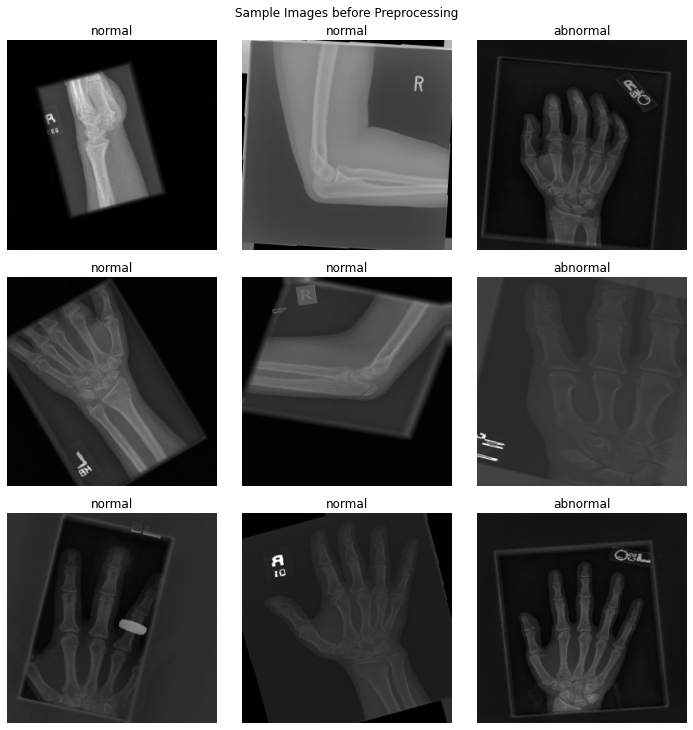

In [38]:
def getImages(batches):
    img_list = []
    imgs, labels = next(iter(train_batches))
    for i in range(9):
        img_list.append({'label': map_label(str(labels[i])), 'image': imgs[i]})
    return img_list

sample_img = getImages(train_batches)
plotImages(sample_img, 'Sample Images before Preprocessing')

# Image Preprocessing

In [39]:
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def threshold_cropping(img):
    # Color to Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Thresholding
    threshold =  cv2.threshold(gray.astype('uint8'), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    #Cropping
    x, y, w, h = cv2.boundingRect(threshold)
    x, y, w, h = x, y, w+20, h+20
    gray = gray[y:y+h, x:x+w]
    return gray

    
        
def canny_cropping(img):
    convert_img = np.array(img, dtype=np.uint8)

    gray = cv2.cvtColor(convert_img, cv2.COLOR_RGB2GRAY)


    ave_brightness = math.floor(np.average(gray))
    min_pixel = min(gray.flatten())

    edges = cv2.Canny(gray, min_pixel, ave_brightness)
    cnts = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    for c in cnts:
        x, y, w, h = cv2.boundingRect(edges)
        gray = gray[y:y+h, x:x+w]
        break

    return gray

def resize_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return cv2.resize(img, (224, 224))

def preprocessing_without_clahe(img):
    cropped = canny_cropping(img)
    return resize_img(cropped)

def preprocessing_with_clahe(img):
    cropped = canny_cropping(img)
    clahe = apply_clahe(cropped)
    return resize_img(clahe)



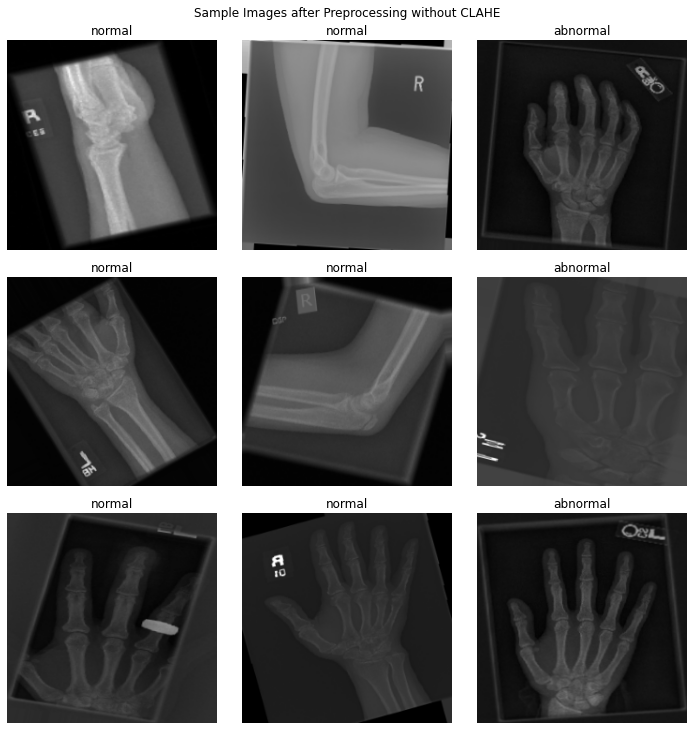

In [40]:
without_clahe = []
for img in sample_img:
    without_clahe.append({'label': img['label'],'image': preprocessing_without_clahe(img['image'])})
plotImages(without_clahe, 'Sample Images after Preprocessing without CLAHE')

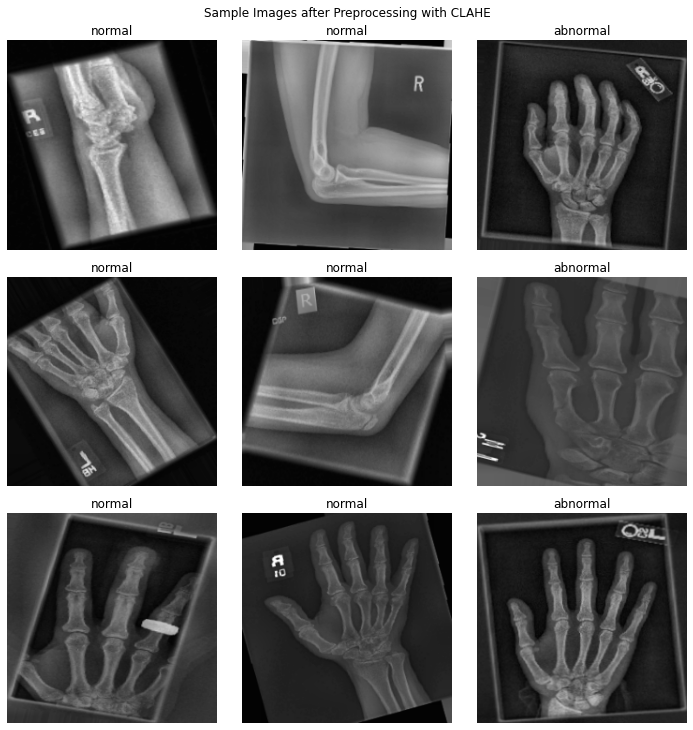

In [41]:
with_clahe = []
for img in sample_img:
    with_clahe.append({'label': img['label'],'image': preprocessing_with_clahe(img['image'])})
plotImages(with_clahe, 'Sample Images after Preprocessing with CLAHE')